# Example: building segmentation with attention U-net/ trans-Unet and transfer learning from ImageNet-trained VGG16 model

In [ ]:
import numpy as np
from glob import glob

In [ ]:
from tensorflow import keras

This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [ ]:
!pip install keras-unet-collection

     |████████████████████████████████| 67 kB 3.0 MB/s 


In [ ]:
from keras_unet_collection import models, utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# file path after data extraction
path_trainval_img = "/content/drive/MyDrive/dataset3/images/res/"
path_trainval_mask = "/content/drive/MyDrive/dataset3/labels/res/"
path_test_img = "/content/drive/MyDrive/dataset2/test/image/res/"
path_test_mask = "/content/drive/MyDrive/dataset2/test/label/res/"

### Subsetting building samples



**Note**: sample subsetting code cells are time-consuming.

In [ ]:
def split_human_samples(label_filenames, human_id=0, human_rate=1/3):
    '''
    Subsetting samples that contain "person/human" category from the COCO dataset
    ----------
    human_id = 0 : COCO stuffthingmaps label human as int 0
    human_rate = 1/3: at least 33% of the pixels should belong to human.
    ----------
    '''
    thres = int(64*64*human_rate) # pixel number thres after resizing
    L = len(label_filenames)
    flag = [] # return a list of booleans
    for i in range(L):
        sample_ = utils.image_to_array([label_filenames[i]], size=128, channel=1)
        if np.sum(sample_[0, 32:-32, 32:-32, 0]==human_id) > thres:
            flag.append(True)
        else:
            flag.append(False)
        
    return flag

In [ ]:
trainval_input_names = np.array(sorted(glob(path_trainval_img+'*.jpg')))
trainval_label_names = np.array(sorted(glob(path_trainval_mask+'*.png')))
flag_human = split_human_samples(trainval_label_names, human_id=0)
trainval_input_names = trainval_input_names[flag_human]
trainval_label_names = trainval_label_names[flag_human]

In [ ]:
test_input_names = np.array(sorted(glob(path_test_img+'*.jpg')))
test_label_names = np.array(sorted(glob(path_test_mask+'*.png')))
flag_human_test = split_human_samples(test_label_names, human_id=0)
test_input_names = test_input_names[flag_human_test]
test_label_names = test_label_names[flag_human_test]

### Training-validation data split


The validation data of this example is split form the training samples. 

In [ ]:
L = len(trainval_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9*L); L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]

train_input_names = trainval_input_names[ind_train]
train_label_names = trainval_label_names[ind_train]
valid_input_names = trainval_input_names[ind_valid]
valid_label_names = trainval_label_names[ind_valid]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names)))

Training:validation:testing = 79:9:4


### Exploratory data analysis

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [ ]:
i_max = 10 # explore 10 images
input_example = utils.image_to_array(train_input_names[:i_max], size=128, channel=3)
label_example = utils.image_to_array(train_label_names[:i_max], size=128, channel=1)

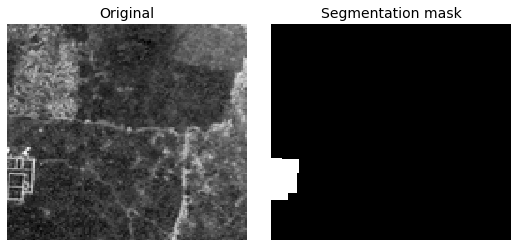

In [ ]:
i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
    
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0]>0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Segmentation mask", fontsize=14);

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of training samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 


 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [ ]:

model = models.transunet_2d((128,128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, stack_num_down=2, stack_num_up=2,
                 embed_dim=768, num_mlp = 3072, num_heads=12, num_transformer=12,
                 activation='ReLU', mlp_activation='GELU', output_activation='Softmax', batch_norm=True, pool=True, unpool=True, 
                 backbone='VGG16', weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='transunet')

# model = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
#                            stack_num_down=2, stack_num_up=2, activation='ReLU', 
#                            atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
#                            batch_norm=True, pool=False, unpool=False, 
#                            backbone='VGG16', weights='imagenet', 
#                            freeze_backbone=True, freeze_batch_norm=True, 
#                            name='attunet')


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [ ]:
from keras_unet_collection import models


In [ ]:
model.layers[1].name

'VGG16_backbone'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [ ]:
from tensorflow import keras

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-2))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [ ]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array>0]=1 # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=2)

In [ ]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=128, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=128, channel=1))

In [ ]:
N_epoch = 5 # number of epoches
N_batch = 10 # number of batches per epoch
N_sample = 20 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 2 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=128, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #
        
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

	Initial loss = 0.5472275614738464
Validation performance is improved from 0.5472275614738464 to 0.4722665548324585
Validation performance is improved from 0.4722665548324585 to 0.45340341329574585
Validation performance is improved from 0.45340341329574585 to 0.4334217309951782
Validation performance is improved from 0.4334217309951782 to 0.40582334995269775
Validation performance is improved from 0.40582334995269775 to 0.39561188220977783


## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [ ]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=128, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=128, channel=1))

In [ ]:
y_pred = model.predict([test_input])

In [ ]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

In [ ]:
i_sample = 2

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);


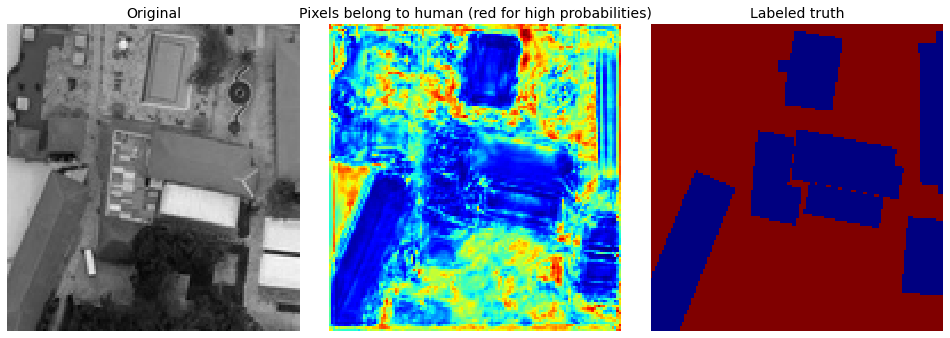

In [ ]:
i_sample = 0

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);

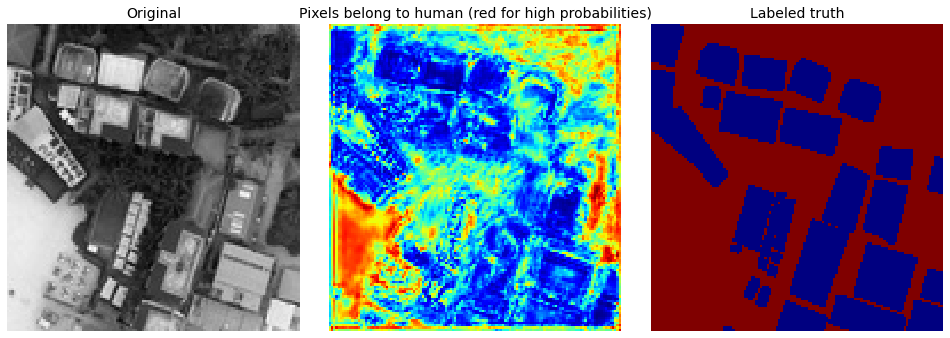

In [ ]:
i_sample = 1

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);

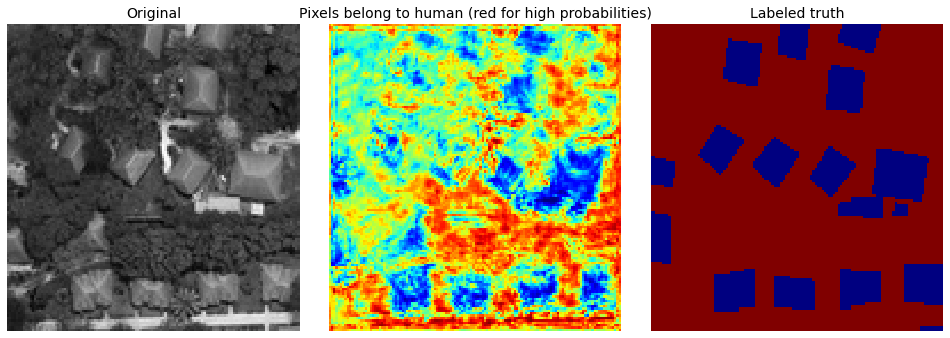

In [ ]:
i_sample = 3

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);

In [ ]:
from keras_unet_collection import losses

In [ ]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))
print('Testing set focal Tversky loss = {}'.format(np.mean(losses.focal_tversky(test_label, y_pred))))
print('Testing set IoU loss = {}'.format(np.mean(losses.iou_seg(test_label, y_pred))))
#print('Testing set focal Tversky loss = {}'.format(np.mean(tf.keras.losses.focal_tversky(test_target[1], y_pred))))
#print('Testing set IoU loss = {}'.format(np.mean(tf.keras.losses.iou_seg(test_target[1], y_pred))))

Testing set cross-entropy = 0.619110643863678


NameError: ignored